We import a few packages such as Pytorch, Matplotlib and Numpy:

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import numpy as np
import torch.optim
import matplotlib.pyplot as plt
import torch.autograd

We create our training and test data:

we discretize the interval $[0,2\pi]$ uniformly with 201 points.

Then, we split this interval in train set $[0,5]$, and test set $[5,2\pi]$.

In [2]:
mesh = torch.linspace(0,2*np.pi,201)
cos_mesh = torch.cos(mesh)
dataset = torch.stack((mesh,cos_mesh))
nb_train = int(dataset.shape[1] *0.8)
data_train = dataset[:,:nb_train]
data_test = dataset[:,nb_train:]


Plot of the cosine function on $[0,2\pi]$

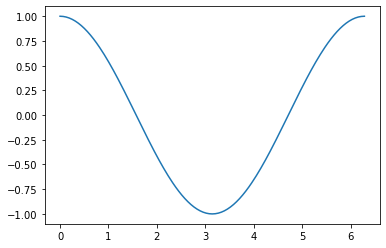

In [3]:
plt.plot(mesh,cos_mesh)
plt.show()

We define our inputs and labels in the getitem method:

In [4]:
class Cosine(Dataset):
    def __init__(self,dataset):
        super().__init__()

        self.dataset = dataset

    def __getitem__(self,idx):
        return self.dataset[0,idx], self.dataset[1,idx]


    def __len__(self):

        return self.dataset.shape[1]   


Regular Neural Network class:

In [5]:
class Neural_Net(nn.Module):
    def __init__(self,nb_layers,input_dim,latent_dim,output_dim,activation):
        super().__init__()

        self.nb_layers = nb_layers
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.activation = activation
        self.layers = nn.ModuleList([nn.Linear(input_dim,latent_dim)])
        for i in range(self.nb_layers-1):
            self.layers.append(nn.Linear(latent_dim,latent_dim))

        self.last_layer = nn.Linear(latent_dim,output_dim)    

    def forward(self,x):

        inputs = [x]
        for j in range(self.nb_layers):
            a = self.layers[j](inputs[j])
            """do not forget ACTIVATION FUNCTION!"""
            if j%2 == 0:
                b = self.activation[0](a)
            else:
                b = self.activation[1](a)    
            inputs.append(b)
        
        output = self.last_layer(inputs[-1])
        return output      


In [6]:
cos_train = Cosine(dataset=data_train)
cos_test = Cosine(dataset=data_test)
BATCH_SIZE = 25
N_EPOCHS = 2000
LR = 1e-3
INPUT_DIM = 1
LATENT_DIM = 20
OUTPUT_DIM = 1
activation = [nn.Tanh(),nn.Tanh()]
NB_LAYERS = 3
EVERY_EP = 200
ALPHA = 0.1

In [7]:
NN = Neural_Net(nb_layers=NB_LAYERS,input_dim=INPUT_DIM,latent_dim=LATENT_DIM,output_dim=OUTPUT_DIM,activation=activation)

In [8]:
optimizer = torch.optim.Adam(NN.parameters(),lr=LR)

In [9]:
train_loader = DataLoader(dataset=cos_train,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=cos_test,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)

We train our baseline NN model with 2000 epochs:

In [10]:
loss_train = 0
l=torch.tensor([0.])
for epoch in range(N_EPOCHS):

    


    for n_batch,batch in enumerate(train_loader):
        x,labels = batch
        outputs = NN(x.view(BATCH_SIZE,INPUT_DIM))
        
        loss = torch.mean((outputs-labels.view(BATCH_SIZE,INPUT_DIM))**2)
           

        loss_train += loss.detach()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_train /= (len(train_loader.dataset))
    loss_train *= BATCH_SIZE 
    
    loss_test = 0
    with torch.no_grad():
        for n_batch,batch in enumerate(test_loader):
            a,l =  batch 

            out = NN(a.view(BATCH_SIZE,INPUT_DIM))
            
            Loss = torch.mean((out-l)**2)    
            loss_test += Loss.detach()
        loss_test /= (len(test_loader.dataset)) 
        loss_test *= BATCH_SIZE       
        
        if epoch%EVERY_EP == 0:
            print(f"Epoch: {epoch} , Loss Train: {loss_train}, Loss Test: {loss_test}")






Epoch: 0 , Loss Train: 0.4294688403606415, Loss Test: 0.4900086224079132


Epoch: 200 , Loss Train: 0.0006254479521885514, Loss Test: 0.04293614253401756
Epoch: 400 , Loss Train: 3.4300945117138326e-05, Loss Test: 0.05147912725806236
Epoch: 600 , Loss Train: 1.7573278455529362e-05, Loss Test: 0.052497752010822296
Epoch: 800 , Loss Train: 5.271505142445676e-05, Loss Test: 0.05212582275271416
Epoch: 1000 , Loss Train: 1.2198890544823371e-05, Loss Test: 0.05128859356045723
Epoch: 1200 , Loss Train: 1.2250924555701204e-05, Loss Test: 0.05081864073872566
Epoch: 1400 , Loss Train: 5.952324499958195e-05, Loss Test: 0.05085411295294762
Epoch: 1600 , Loss Train: 5.35910548933316e-05, Loss Test: 0.050811078399419785
Epoch: 1800 , Loss Train: 4.152085239184089e-05, Loss Test: 0.049933161586523056


We see here under that the model learns well on the training data, but does not have good performances on the test set.

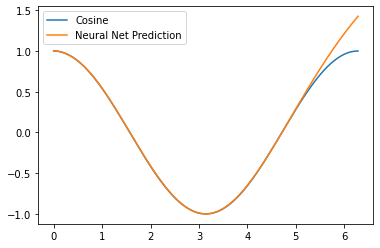

In [11]:
import matplotlib.pyplot as plt

grid = torch.linspace(0,2*np.pi,200).view(200,1)
cos_grid = torch.cos(grid)
y_prediction = NN(grid).detach()

plt.plot(grid,cos_grid,label='Cosine')
plt.plot(grid,y_prediction,label='Neural Net Prediction')
plt.legend()



We are now going to learn the Cosine function using a completely different method called

Physics-Informed Neural Networks ($PINNs$):

Consider the following differential equation with two initial conditions:


$y''(x)+ y(x) = 0, x \in [0,2\pi] ,$
            
$y(0) = 1, $
             
$y'(0) = 0$











We know this equation has a unique solution: the cosine.

Neural Networks are universal approximators of continuous functions (on compact sets).

The idea of PINNs is to parameterize $y$ as a Neural Network $y_\theta$ :

thanks to Automatic Differentiation and more particularly the torch.autograd package, we 

can compute the derivative $ \frac{\partial y}{\partial x}$ (that is $y'$), and then $ \frac{\partial^2 y}{\partial x^2}$(that is $y''$) at any point $x$,

 here we choose to evaluate at the points $x_k = \frac{2k\pi}{n} , k \in{0,...,n}$ (and we decide that $n = 14$).

Now let us consider the three following losses:

$L_1 = (y_\theta(0)-1)^2$  

$L_2 = y'_\theta(0)^2$   

$L_3 = (\sum_{k=1}^{n} y''(x_k) + y(x_k))^2$ 


Denoting the final loss $L_\theta$, we have:

$L_\theta = \frac{1}{n}(L_1+L_2+L_3)$

and we will minimize $L_\theta$ in order to get a solution that respects this differential equation.

In [12]:
Physics_NN = Neural_Net(nb_layers=2,input_dim=1,latent_dim=20,output_dim=1,activation=activation)

<ipython-input-13-5b15cc03685e>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.scatter(x.detach(),torch.cos(x.detach()),Color='g')


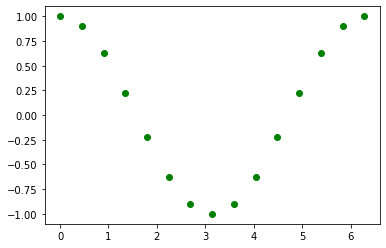

In [13]:
physics_optimizer = torch.optim.Adam(Physics_NN.parameters(),lr=LR)
epochs = 5000
nb_points = 15
x = torch.linspace(0,2*np.pi,nb_points).view(nb_points,1).requires_grad_()
plt.scatter(x.detach(),torch.cos(x.detach()),Color='g')


Here under, we learn the parameters $\theta$ : we expect to get a prediction that respects both the differential equation,

and the initial conditions, thus should give a correct approximation of the cosine.

In [14]:
for ep in range(epochs):
    
        
    y = Physics_NN(x)
    dy_dx = torch.autograd.grad(y,x,torch.ones_like(y),create_graph=True)[0] ###first derivative of y w.r.t x
    
    dy_dxx = torch.autograd.grad(dy_dx,x,torch.ones_like(dy_dx),create_graph=True)[0] ### second derivative of y w.r.t x
    loss_ic_y = (y[0]-1)**2   ### ic stands for initial condition, initial condition y(0) = 1
    loss_ic_dy = (dy_dx[0])**2   ### initial condition on the first derivative y'(0) = 0
    loss_physics = (dy_dxx+y)**2    ### we define y''+ y  
    loss = loss_ic_y + loss_ic_dy + torch.mean(loss_physics)
        
    loss.backward()
    physics_optimizer.step()  ### we minimize the sum of loss_physics and the two ic's so that the Differential Equation loss is small and also the IC terms are small
    physics_optimizer.zero_grad()   
     

    if ep%100==0:
        print('loss',loss.item(),'epoch',ep)

    
    


    

loss 1.723625659942627 epoch 0
loss 0.10285481810569763 epoch 100
loss 0.08465363830327988 epoch 200
loss 0.07546192407608032 epoch 300
loss 0.06919681280851364 epoch 400
loss 0.06374379247426987 epoch 500
loss 0.05809992179274559 epoch 600
loss 0.05192752555012703 epoch 700
loss 0.04570543020963669 epoch 800
loss 0.04028959944844246 epoch 900
loss 0.03621300682425499 epoch 1000
loss 0.03337540850043297 epoch 1100
loss 0.031379975378513336 epoch 1200
loss 0.029895108193159103 epoch 1300
loss 0.028726212680339813 epoch 1400
loss 0.027765052393078804 epoch 1500
loss 0.026947319507598877 epoch 1600
loss 0.02623358927667141 epoch 1700
loss 0.025600004941225052 epoch 1800
loss 0.02503145858645439 epoch 1900
loss 0.024517104029655457 epoch 2000
loss 0.024041729047894478 epoch 2100
loss 0.023581361398100853 epoch 2200
loss 0.02309424616396427 epoch 2300
loss 0.02250559628009796 epoch 2400
loss 0.02170843444764614 epoch 2500
loss 0.020589176565408707 epoch 2600
loss 0.019004276022315025 epoch 

In the beggining we only had $15$ points. Below we discretize more densely ($500$ points).

 We do not see any difference between the true Cosine function and the Neural Network prediction.

With only $15$ 'data' points, the Physics-Informed Neural Network method performs very well.

We do not need many points to obtain a good result (at least in dimension $1$).

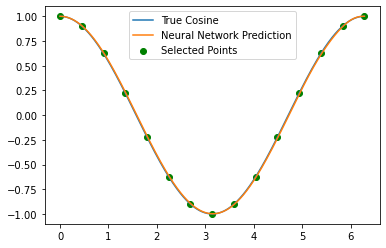

In [15]:
import matplotlib.pyplot as plt

grid = torch.linspace(0,2*np.pi,500).view(500,1).detach()

cos_grid = np.cos(grid)
physics_prediction = Physics_NN(grid).detach()
plt.scatter(x.detach(),torch.cos(x.detach()),color='g',label='Selected Points')
plt.plot(grid,cos_grid,label='True Cosine')
plt.plot(grid,physics_prediction,label='Neural Network Prediction')
plt.legend()

We can compute the Mean Squared Error between our $NN$ prediction and the true solution:

the error is around $8.10^{-5}$ which is very low.

In [16]:
criterion = nn.MSELoss()

In [17]:
print('Mean Square Error',criterion(physics_prediction,torch.cos(grid)).item())

Mean Square Error 7.960153016028926e-05
